# Прогнозирование уровня заработной платы в России

### Визуальный анализ ряда

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


E:\work\tools\python\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


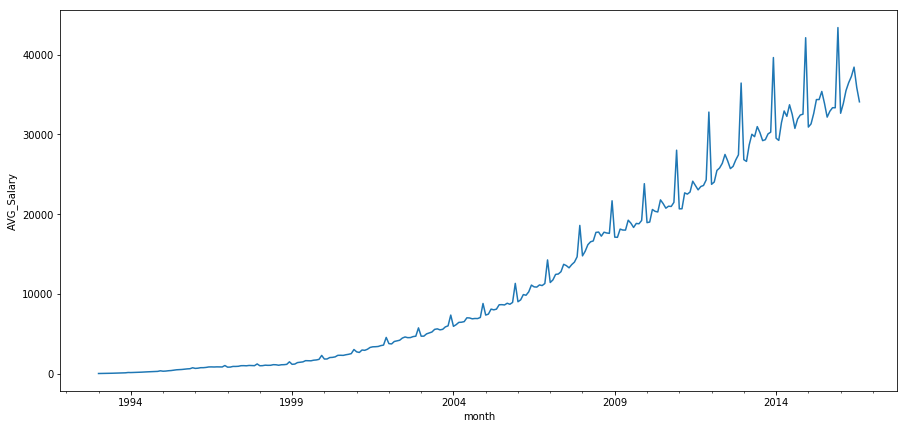

In [3]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel('AVG_Salary')
pylab.show()

Проверим стационарность:

In [4]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Тренд и сезонность:

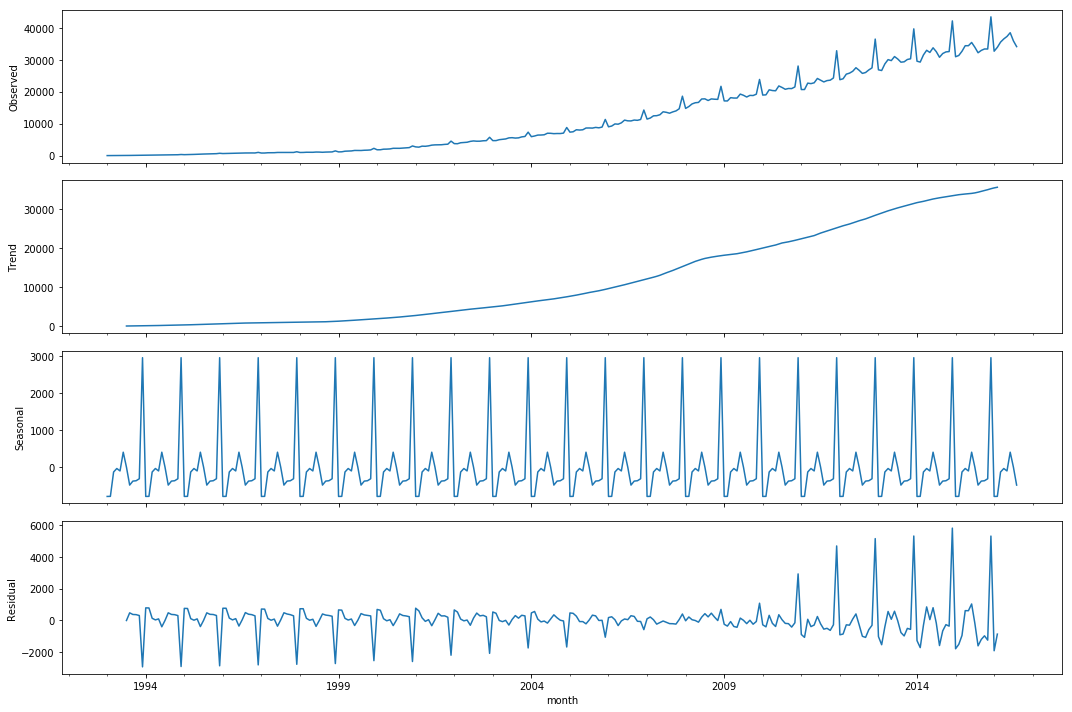

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
plt.show()

Гипотеза нестационарности не отвергается. У ряда выраженный тренд и сезонность. Дисперсия значений в начале ряда меньше дисперсии значений в конце. 

### Стабилизация дисперсии

Преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


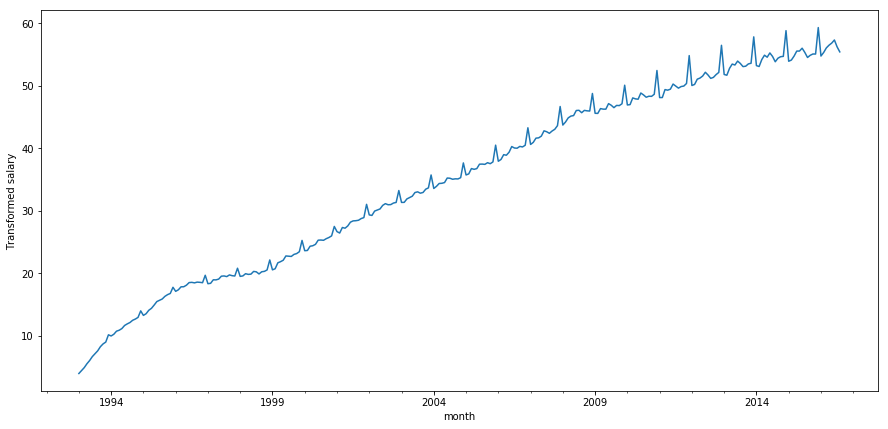

In [6]:
df['sales_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.sales_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box)[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, в данных виден тренд.

### Выбор порядка дифференциирования

Проведем сезонное дифференциирование, сезон - 12 месяцев. Проведем над дифференциированным рядом декомпозицию, проверим стационарность.

Критерий Дики-Фуллера: p=0.014697


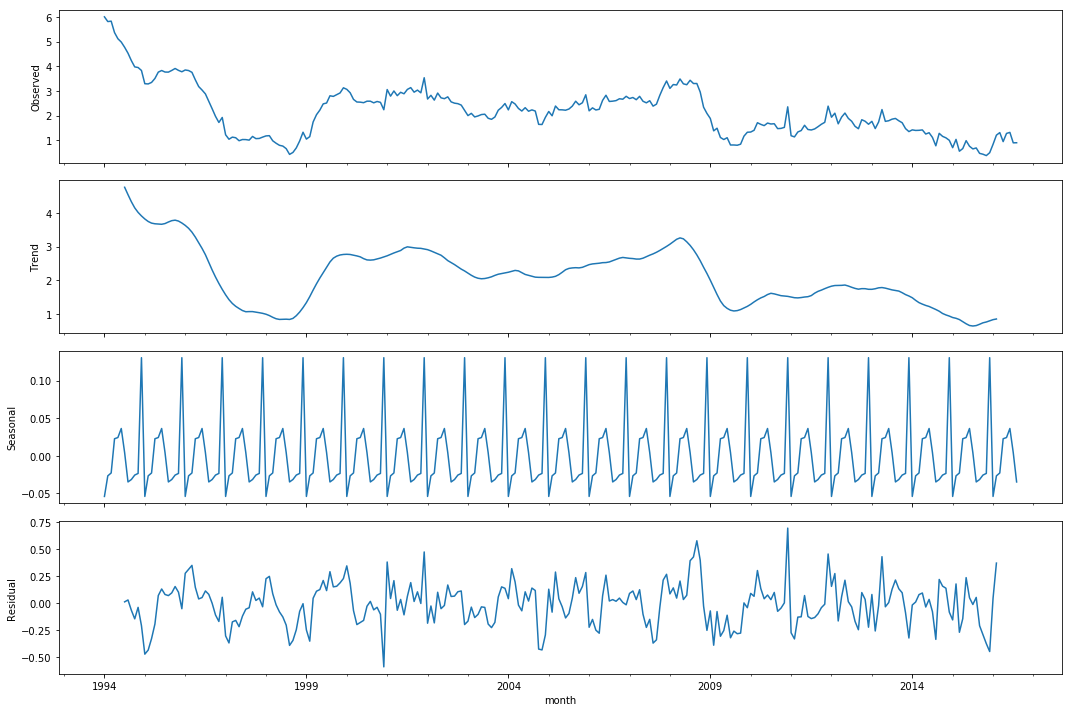

In [7]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1])
plt.show()

Критерий отвергает гипотезу стационарности. Проведем обычное дифференциирование:

Критерий Дики-Фуллера: p=0.000000


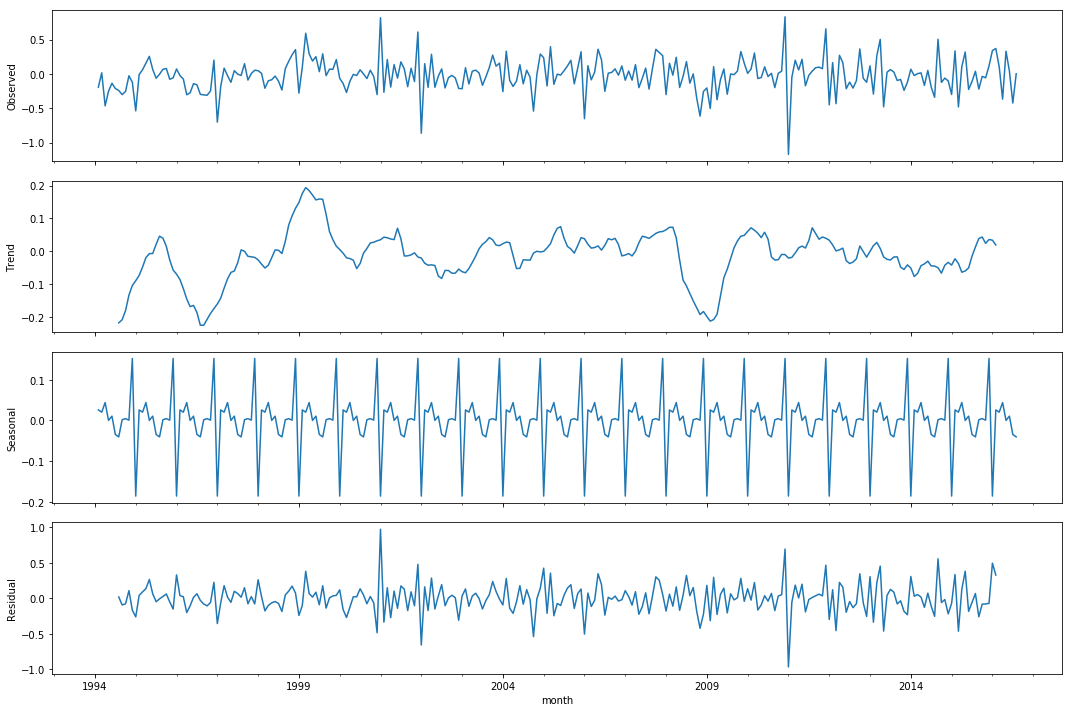

In [8]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1])

Удалось избавиться от тренда.

### Выбор начальных приближений для p,q,P,Q

Посмотрим на автокорреляцию и частичную автокорреляцию:

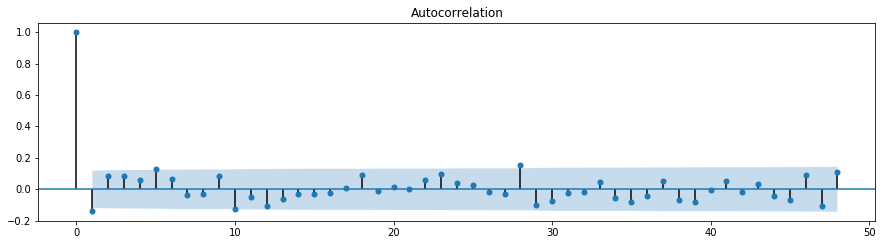

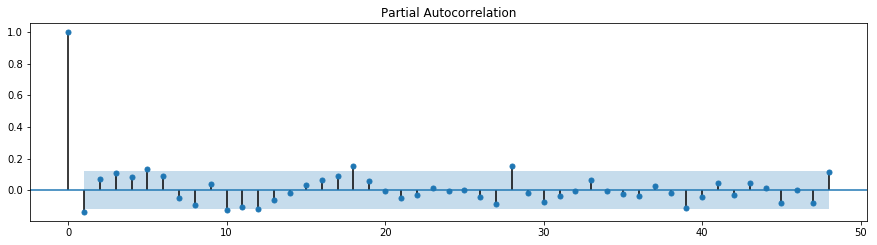

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выберем начальные приближения: Q=1, q=2, P=1, p=4

In [10]:
ps = range(0, 3)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

### Обучение и сравнение моделей-кандидатов, выбор победителя

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
Wall time: 9.65 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
9   (1, 0, 1, 0)  0.340521
10  (1, 0, 1, 1)  0.492412
8   (1, 0, 0, 1)  0.774438
5   (0, 1, 1, 0)  1.170768
6   (0, 1, 1, 1)  1.342395


In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 15 Dec 2018   AIC                              0.341
Time:                                    19:00:52   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

### Анализ остатков построенной модели

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


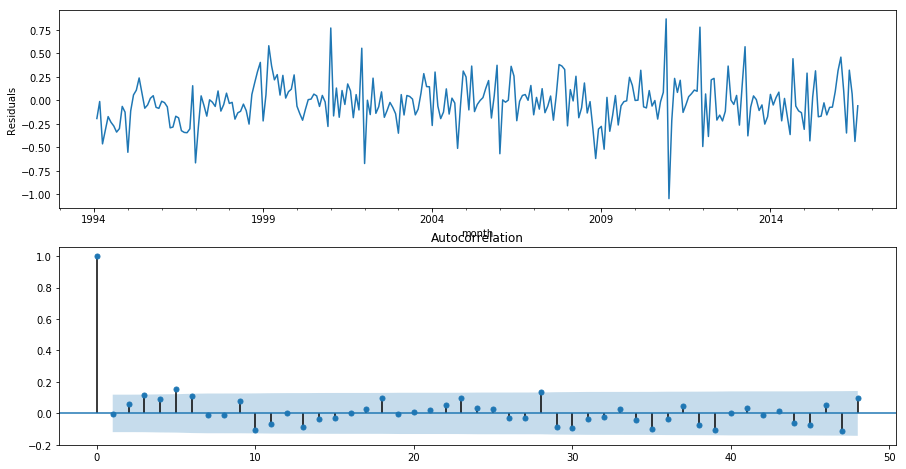

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены, неавтокоррелированы и стационарны. Проверим насколько хорошо модель описывает данные:

In [16]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

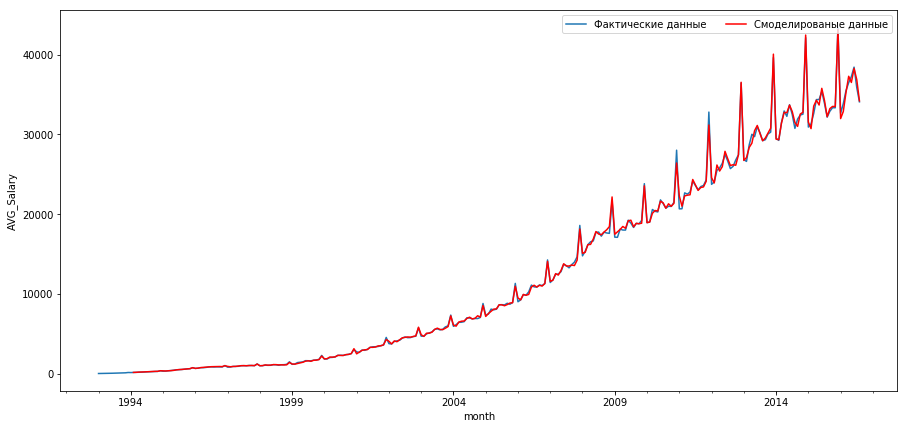

In [17]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.legend( [u'Фактические данные', u'Смоделированые данные'], loc=1, ncol = 2, prop={'size':10})
plt.ylabel('AVG_Salary')
pylab.show()

### Прогнозирование с помощью финальной модели

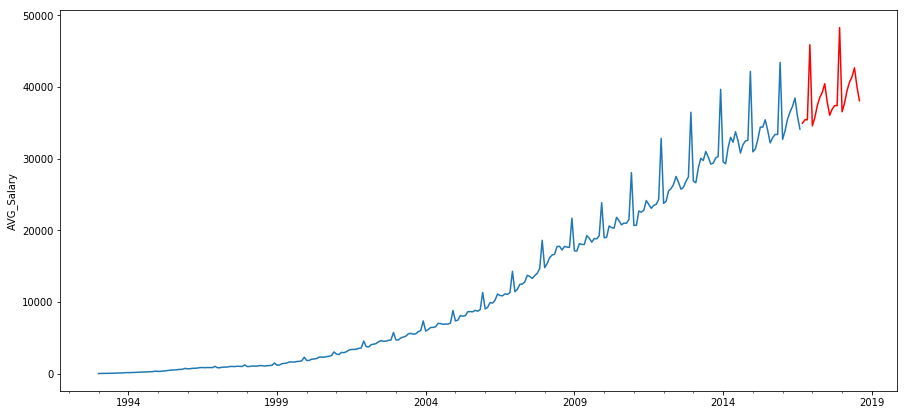

In [18]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('AVG_Salary')
pylab.show()